In [12]:
import lightgbm as lgb
from pathlib import Path
import preprocessing as preprpcessing

import pandas as pd
import preprocessing
from pathlib import Path

DATA_DIR = Path("..","data")
COMMON_DATA_DIR = Path("..","..","common","src","data")
RAWDF_DIR = COMMON_DATA_DIR/"rawdf"
INPUT_DIR = COMMON_DATA_DIR / "rawdf"
MAPPING_DIR = COMMON_DATA_DIR / "mapping"
OUTPUT_DIR = Path("..", "data", "01_preprocessed")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload

In [8]:
df = pd.read_csv(INPUT_DIR / "20241124_202405050812results.csv", sep="\t")

In [32]:
df

,race_id,枠,馬番,馬名,性齢,斤量,騎手,厩舎,馬体重(増減),人気,グループ,予想オッズ,horse_id,jockey_id,trainer_id
0,202405050812,1,1,ゴリアット,セ4,58.0,スミヨン,海外グラファー,495(0),9,NaN,19.3,2020190005,5271,5701
1,202405050812,2,2,ブローザホーン,牡5,58.0,菅原明,栗東吉岡,432(6),10,NaN,34.1,2019105748,1179,1176
2,202405050812,3,3,ドウデュース,牡5,58.0,武豊,栗東友道,518(14),1,NaN,2.4,2019105283,666,1061
3,202405050812,3,4,ジャスティンパレス,牡5,58.0,Ｃデムーロ,栗東杉山晴,472(2),3,NaN,7.1,2019105346,5473,1157
4,202405050812,4,5,シュトルーヴェ,セ5,58.0,鮫島駿,美浦堀,484(14),11,NaN,40.7,2019104447,1157,1070
5,202405050812,4,6,ダノンベルーガ,牡5,58.0,松山,美浦堀,502(4),12,NaN,61.1,2019105195,1126,1070
6,202405050812,5,7,シンエンペラー,牡3,56.0,坂井,栗東矢作,490(0),7,NaN,14.8,2021110048,1163,1075
7,202405050812,5,8,オーギュストロダン,牡4,58.0,ムーア,海外Ａオブライ,452(0),5,NaN,12.6,2020190003,5366,5518
8,202405050812,6,9,チェルヴィニア,牝3,54.0,ルメール,美浦木村,502(12),2,NaN,3.3,2021105643,5339,1126
9,202405050812,6,10,ドゥレッツァ,牡4,58.0,ビュイック,美浦尾関,472(0),6,NaN,12.8,2020103650,5495,1103


In [13]:
INPUT_DIR2 = Path("..","data","02_features")
features = pd.read_csv(INPUT_DIR2 / "features.csv", sep = "\t")

In [24]:
print(features)

            race_id    horse_id        date  jockey_id  trainer_id  rank  sex  \
0      202301010101  2021100648  2023-07-22       1095        1128     5    1   
1      202301010101  2021100159  2023-07-22       1157        1186     6    0   
2      202301010101  2021100265  2023-07-22       1197        1192     7    1   
3      202301010101  2021105553  2023-07-22       5339        1160     4    1   
4      202301010101  2021101429  2023-07-22       1170        1026     1    0   
...             ...         ...         ...        ...         ...   ...  ...   
88358  202410030812  2020101594  2024-07-21       1187        1135     3    0   
88359  202410030812  2021104131  2024-07-21       1018        1003     5    0   
88360  202410030812  2020103212  2024-07-21       5212        1061     7    0   
88361  202410030812  2020103550  2024-07-21       1154        1121    10    0   
88362  202410030812  2021101090  2024-07-21       1204        1170    14    1   

       age  weight  weight_

In [63]:
df_prediction = pd.merge(features,df["horse_id"], on="horse_id")

In [35]:
df_prediction["horse_id"].unique()

array([2019105748, 2019105195, 2016106606, 2021105643, 2020103650,
       2019104447, 2019104740, 2020102899, 2019105283, 2019105346,
       2021110048])

In [37]:
df_prediction.columns

Index(['race_id', 'horse_id', 'date', 'jockey_id', 'trainer_id', 'rank', 'sex',
       'age', 'weight', 'weight_diff', 'tansho_odds', 'popularity', 'impost',
       'wakuban', 'umaban', 'race_type', 'around', 'course_len', 'weather',
       'ground_state', 'race_class', 'place', 'rank_1race', 'prize_1race',
       'rank_3races', 'prize_3races', 'rank_5races', 'prize_5races',
       'rank_10races', 'prize_10races', 'rank_1000races', 'prize_1000races'],
      dtype='object')

In [51]:
feature_cols = [
    'horse_id', 
    'jockey_id', 
    'trainer_id', 
    'sex',
    'age', 
    'weight', 
    'weight_diff', 
    # 'tansho_odds', 
    # 'popularity', 
    'impost',
    'wakuban', 
    'umaban', 
    'race_type', 
    'around', 
    'course_len', 
    'weather',
    'ground_state', 
    'race_class',
    'place',
    'rank_1race',
    'prize_1race',
    'rank_3races',
    'prize_3races',
    'rank_5races',
    'prize_5races',
    'rank_10races',
    'prize_10races',
    'rank_1000races',
    'prize_1000races'
]
#説明変数
X = df_prediction[feature_cols]
#目的変数
df_prediction["target"] = (df_prediction["rank"] == 1).astype(int)

In [52]:
train_df = df_prediction.query("date < '2024-08-01' and date > '2024-01-01'")
test_df = df_prediction.query("date >= '2024-08-01'")



In [45]:
len(train_df),len(test_df)

(25, 7)

In [53]:
#データセットの作成
lgb_train = lgb.Dataset(
    train_df[feature_cols], train_df["target"]
)

lgb_test = lgb.Dataset(
    test_df[feature_cols], test_df["target"]
)

#パラメータの設定
params = {
    "objective": "binary", # 二値分類
    "metric": "binary_logloss", # 予測誤差
    "random_state":100 # 実行ごとに同じ結果を得るための設定
}

#学習の実行
model2 = lgb.train(
    params = params,
    train_set = lgb_train,
    valid_sets = [lgb_train, lgb_test],
    callbacks = [lgb.log_evaluation()]
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 6, number of negative: 19
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240000 -> initscore=-1.152680
[LightGBM] [Info] Start training from score -1.152680
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	training's binary_logloss: 0.55108	valid_1's binary_logloss: 0.603774
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	training's binary_logloss: 0.55108	valid_1's binary_logloss: 0.603774
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	

In [65]:
#馬体重はハンドで加工済み

# レース結果テーブルの前処理
# results_predict = preprpcessing.process_race(
#     save_filename="20241124_202405050812results.csv"
# )
results_predict = pd.read_csv(OUTPUT_DIR/ "20241124_202405050812results.csv", sep="\t")

feature_cols = [
    'horse_id', 
    'jockey_id', 
    'trainer_id', 
    'sex',
    'age', 
    'weight', 
    'weight_diff', 
    # 'tansho_odds', 
    # 'popularity', 
    'impost',
    'wakuban', 
    'umaban', 
    'race_type', 
    'around', 
    'course_len', 
    'weather',
    'ground_state', 
    'race_class',
    'place',
    'rank_1race',
    'prize_1race',
    'rank_3races',
    'prize_3races',
    'rank_5races',
    'prize_5races',
    'rank_10races',
    'prize_10races',
    'rank_1000races',
    'prize_1000races'
]


# モデルの読み込み
model = lgb.Booster(model_file=Path("..", "model", "model.txt"))




In [73]:
results_predict = pd.merge(results_predict,df_prediction[["horse_id","rank_1race","prize_1race","rank_3races","prize_3races","rank_5races","prize_5races","rank_10races","prize_10races","rank_1000races","prize_1000races"]],on = "horse_id")

In [77]:
results_predict["race_type"] = 1
results_predict["around"] = 1
results_predict["course_len"] = 2400
results_predict["weather"] = 0
results_predict["ground_state"] = 0
results_predict["race_class"] = 8
results_predict["place"] = results_predict["race_id"].astype(str).str[4:6].astype(int)


In [103]:
results_predict["horse_id"].unique()

array([2019105748, 2019105283, 2019105346, 2019104447, 2019105195,
       2021110048, 2021105643, 2020103650, 2016106606, 2020102899,
       2019104740])

In [96]:
# テストデータに対して予測をしてみる
results_predict["pred"] = model.predict(results_predict[feature_cols])

# 確認に必要なデータだけ抽出
df = results_predict[
    [
        "race_id",
        "umaban",
        "pred",
        "yosou_odds",
        "popularity"
    ]
].copy()
df.sort_values("pred", ascending=False)

,race_id,umaban,pred,yosou_odds,popularity
43,202405050812,9,0.453842,3.3,2
12,202405050812,3,0.353716,2.4,1
41,202405050812,9,0.323441,3.3,2
40,202405050812,9,0.322658,3.3,2
42,202405050812,9,0.296820,3.3,2
...,...,...,...,...,...
55,202405050812,11,0.013938,279.0,14
56,202405050812,11,0.007462,279.0,14
59,202405050812,11,0.002530,279.0,14
60,202405050812,11,0.002190,279.0,14


In [97]:
# テストデータに対して予測をしてみる
results_predict["pred"] = model2.predict(results_predict[feature_cols])

# 確認に必要なデータだけ抽出
df2 = results_predict[
    [
        "race_id",
        "umaban",
        "pred",
        "yosou_odds",
        "popularity"
    ]
].copy()
df2.sort_values("pred", ascending=False)

,race_id,umaban,pred,yosou_odds,popularity
0,202405050812,2,0.24,34.1,10
1,202405050812,2,0.24,34.1,10
2,202405050812,2,0.24,34.1,10
3,202405050812,2,0.24,34.1,10
4,202405050812,2,0.24,34.1,10
...,...,...,...,...,...
70,202405050812,12,0.24,15.8,8
71,202405050812,14,0.24,10.6,4
72,202405050812,14,0.24,10.6,4
73,202405050812,14,0.24,10.6,4


In [81]:
import graphviz
import matplotlib.pyplot as plt

# オフライン評価
的中率・回収率を見てみる

In [101]:
df.to_csv(DATA_DIR / "03_prediction" / "all_data_prediction.csv", sep="\t", index=False)

In [108]:
bet_df = (
    df
    .sort_values("pred",ascending=False)
    .groupby("umaban")
    .head(1)
    # .tail(1)
)
bet_df

,race_id,umaban,pred,yosou_odds,popularity
43,202405050812,9,0.453842,3.3,2
12,202405050812,3,0.353716,2.4,1
17,202405050812,4,0.286577,7.1,3
53,202405050812,11,0.232070,279.0,14
27,202405050812,5,0.227063,40.7,11
33,202405050812,6,0.220172,61.1,12
67,202405050812,12,0.179065,15.8,8
7,202405050812,2,0.178811,34.1,10
47,202405050812,10,0.157739,12.8,6
36,202405050812,7,0.149681,14.8,7


賭け方
単勝　9 チェルヴィニア　1000
    　3 ドウデュース　500
馬連　9-3 500
     9-4 500
3連単　9-3-4 500
3連複　9-3-4 1000
       9-3-11 500
       9-3-1 500



In [102]:
df2.to_csv(DATA_DIR / "03_prediction" / "only_syussouba_prediction.csv", sep="\t", index=False)

In [110]:
bet_df2 = (
    df2
    .sort_values("pred",ascending=False)
    .groupby("umaban")
    .head(1)
    # .tail(1)
)
bet_df2

,race_id,umaban,pred,yosou_odds,popularity
0,202405050812,2,0.24,34.1,10
10,202405050812,3,0.24,2.4,1
16,202405050812,4,0.24,7.1,3
23,202405050812,5,0.24,40.7,11
30,202405050812,6,0.24,61.1,12
34,202405050812,7,0.24,14.8,7
40,202405050812,9,0.24,3.3,2
46,202405050812,10,0.24,12.8,6
52,202405050812,11,0.24,279.0,14
61,202405050812,12,0.24,15.8,8


predの値が一番高いものに、単勝馬券で賭ける場合を考える

In [87]:
bet_df = (
    evaluation_df
    .sort_values("pred",ascending=False)
    .groupby("race_id")
    .head(1)
    # .tail(1)
)


In [88]:
#的中率
bet_df["target"].mean()

np.float64(0.25)

In [89]:
#返ってくる金額
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
return_

np.float64(2.3)

In [90]:
#賭けた金額
cost = len(bet_df)
cost

4

In [91]:
#回収率
return_ / cost

np.float64(0.575)

In [ ]:
import matplotlib

## 特徴量重要度
モデルにインプットしたデータの中で、どの特徴量（列）が一番学習に使われているか

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

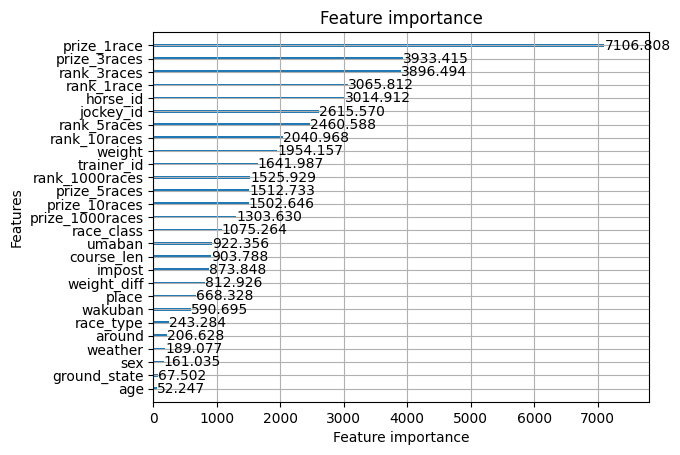

In [ ]:
lgb.plot_importance(model,importance_type="gain")

In [105]:
lgb.plot_importance(model2,importance_type="gain")

ValueError: not enough values to unpack (expected 2, got 0)